<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/8.recurrent_neural_networks/8_1_sequence_models_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import torch
from torch import nn
import numpy as np
from torch.utils import data
import matplotlib.pyplot as plt

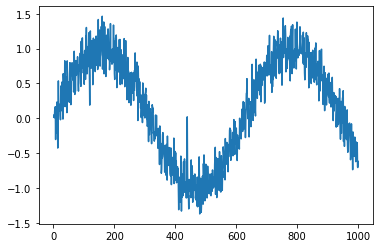

In [57]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
plt.plot(time, x)

In [58]:
tau = 4
features = torch.zeros((T - tau, tau))
features.shape

torch.Size([996, 4])

In [59]:
for i in range(tau):
  features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [60]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [61]:
batch_size, n_train = 16, 600
train_iter = load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [62]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

In [63]:
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

In [64]:
loss = nn.MSELoss(reduction='none')

In [65]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [66]:
def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [67]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {evaluate_loss(net, train_iter, loss):f}')

In [68]:
net = get_net()
train(net, train_iter, loss, 20, 0.01)

epoch 1, loss: 0.060824
epoch 2, loss: 0.057434
epoch 3, loss: 0.055046
epoch 4, loss: 0.055645
epoch 5, loss: 0.052402
epoch 6, loss: 0.053047
epoch 7, loss: 0.052470
epoch 8, loss: 0.051953
epoch 9, loss: 0.050970
epoch 10, loss: 0.053200
epoch 11, loss: 0.050840
epoch 12, loss: 0.051774
epoch 13, loss: 0.053424
epoch 14, loss: 0.051229
epoch 15, loss: 0.052641
epoch 16, loss: 0.050205
epoch 17, loss: 0.052312
epoch 18, loss: 0.050838
epoch 19, loss: 0.050557
epoch 20, loss: 0.050570


In [69]:
onestep_preds = net(features)

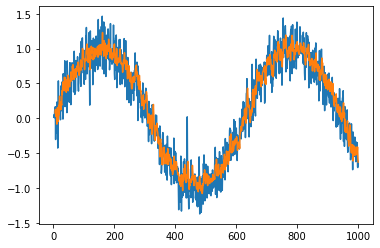

In [70]:
plt.plot(time, x.detach().numpy(), label='data')
plt.plot(time[tau:], onestep_preds.detach().numpy(), label='predict')

In [71]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[: n_train + tau]

In [72]:
for i in range(n_train + tau, T):
  multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

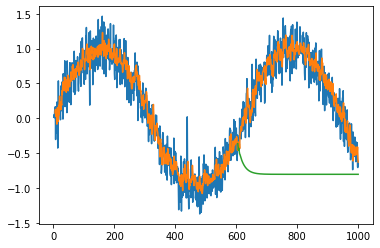

In [73]:
plt.plot(time, x.detach().numpy(), label='data')
plt.plot(time[tau:], onestep_preds.detach().numpy(), label='predict')
plt.plot(time[n_train + tau:], multistep_preds[n_train + tau:].detach().numpy(), label='multistep preds')

In [74]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
print(f'feature shape: {features.shape}')

feature shape: torch.Size([933, 68])


In [75]:
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

In [76]:
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

In [77]:
steps = (1, 4, 16, 64)

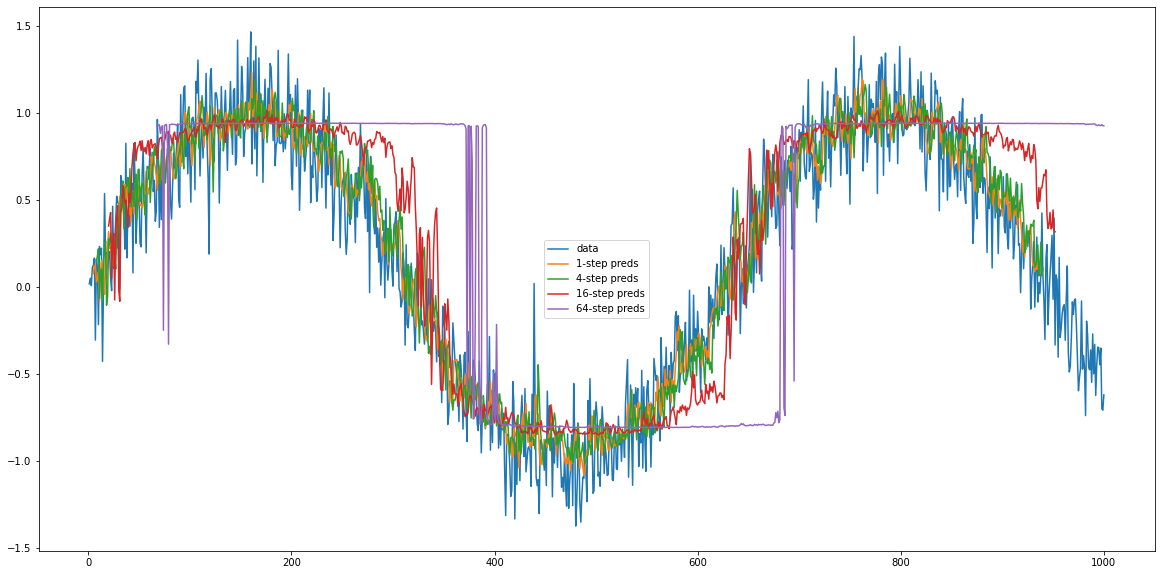

In [84]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(time, x, label= 'data')
for i in steps:
  plt.plot(time[tau + i - 1: T - max_steps + i], features[:, (tau + i - 1)].detach().numpy(), label=f'{i}-step preds')
plt.legend(loc="center")